# Architectures to solve simple memory tasks

This repo is to experiment with implementing simple memory tasks in RL. 

Thanks to Tristan Deleu for helping me with the code. Thanks for Anthony Chen, this idea come up because of my conversation with him.

Architectures to try:
- LSTM-based controller for DQN
- External memory, NTM style
- Just exponentially decay state space and feed to agent. (Maybe later use a more efficient way, or learn how to decay the state)



## Setting up gym environment

In [0]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from gym.utils import seeding

### Remember lights task

In [0]:
class RememberLights(gym.Env):
  def __init__(self, size=2, p=0, delay=3):
    
    # Setting things up
    self.updates = 0
    self.action_space = spaces.Discrete(2) # 0 - b1, 1 - b2
    self.observation_space = spaces.Box(low=np.zeros(2), high=np.ones(2), dtype=np.uint8) # as the state space is one hot encoded
    self.p = p # stocasticity
    self.delay = delay

    # Reward values
    self.correct_reward = 1
    self.wrong_reward = -1

  def reset(self):
    self.updates = 0
    self.lights = random.choice([[0,1],[1,0]])
    return self.lights

  def step(self, action):

    # Making sure valid action is chosen
    assert self.action_space.contains(action)

    self.updates += 1

    # If the environment is stocastic, you move equivalent to taking a random action
    if(np.random.rand() <= self.p):
      action = np.random.randint(low=0, high=2)

    
    done = False
    R = 0
    state = [0, 0]
    if(self.updates == self.delay):
      state = [1, 1] # choose now indicator
    elif(self.updates == self.delay + 1):
      done = True
      if(self.lights[action] == 1):
        R = self.correct_reward
      else:
        R = self.wrong_reward

    return state, R, done, {}


### Line world task

In [0]:
class LineWorld():
    """
    """
    def __init__(self, n=5):

        # Initialzing required parameters
        self.update_count = 0
        self.n = n # Length of the chain
        self.state = (n-1) // 2  # Start at middle of the chain
        self.action_space = spaces.Discrete(2) # Number of actions: 2 - [0: left, 1: right]
        # self.observation_space = spaces.Discrete(self.n) # number of states is equal to chain length
        self.observation_space = spaces.Box(low=np.zeros(n), high=np.ones(n), dtype=np.uint8)
        # Setting reward values
        self.step_reward = -1
        
        self.seed() # not sure what this does, so not changing it

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        '''
        takes an action as an argument and returns the next_state, reward, done, info.
        '''
        
        # Making sure valid action is chosen
        assert self.action_space.contains(action)

        self.update_count += 1

        # Stepping along on the chain
        if(action == 0):
            self.state = self.state - 1
        else:
            self.state = self.state + 1

        # Because this is a continuing case
        if((self.state == self.n-1) or (self.state == 0)):
            done = True
            reward = self.step_reward
        else:
            done = False
            reward = self.step_reward
        temp = np.zeros(self.observation_space.shape)
        temp[self.state] = 1

        return temp, reward, done, {}

    def reset(self):
        '''
        transitions back to first state
        '''
        self.update_count = 0 
        self.state = (self.n - 1) // 2
        temp = np.zeros(self.observation_space.shape)
        temp[self.state] = 1
        return temp

### Lineworld with memory task

In [0]:
class LineWorldMemory(gym.Env):
  def __init__(self, size=5, p=0, horizon=100):
    
    # Setting things up
    self.updates = 0
    self.size = size # size of the chain
    self.loc = (self.size - 1) // 2 # Start at the middle
    self.action_space = spaces.Discrete(4) # 0 - left, 1 - right, 2 - click blue, 3 - click green
    self.observation_space = spaces.Box(low=np.zeros(size+2), high=np.ones(size+2), dtype=np.uint8) # as the state space is one hot encoded
    self.p = p # stocasticity
    self.horizon = horizon

    # object choice
    self.color = random.choice(['blue', 'green'])
    self.color2val = {'blue':0, 'green':1}

    # Reward values
    self.step_reward = -0.1
    self.correct_reward = 0
    self.wrong_reward = -2

  def reset(self):
    self.updates = 0
    self.loc = (self.size - 1) // 2 # Start at the middle
    self.color = random.choice(['blue', 'green'])
    return self._loc2state(self.loc)

  def _loc2state(self, loc):
    temp = np.zeros(self.observation_space.shape[0])
    temp[loc] = 1
    if(self.loc == 0):
      temp[self.size + self.color2val[self.color]] = 1
    return temp

  def step(self, action):

    # Making sure valid action is chosen
    assert self.action_space.contains(action)

    self.updates += 1

    # If the environment is stocastic, you move equivalent to taking a random action
    if(np.random.rand() <= self.p):
      action = np.random.randint(low=0, high=4)

    done = False
    # Checking for termination
    R = self.step_reward
    if(self.updates >= self.horizon):
      done = True
    elif((self.loc == self.size-1)):
      done = True
      if(action-2 == self.color2val[self.color]):
        R = self.correct_reward
      else:
        R = self.wrong_reward

    if(not done):
      # Stepping along on the chain
      if(action == 0):
          self.loc = self.loc - 1
      elif(action == 1):
          self.loc = self.loc + 1

      # Compensating for walls
      if(self.loc < 0):
        self.loc = 0
      elif(self.loc >= self.size):
        self.loc = self.size - 1

    
        
    return self._loc2state(self.loc), R, done, {}

  def render(self, mode='human', printR=False, cs=100):
    '''Rendering the state of environment
    
    passing for now, need to implement a nice visualization later.
    
    '''
    self.cs = cs
    h = self.size*cs
    w = cs
    img = Image.new('RGBA', (h, w), "white")
    draw = ImageDraw.Draw(img)

    for i in range(1, self.size):
    	draw.line([cs*i, 0, cs*i, h], fill="gray", width=10)
     
    for i in range(0, self.size):
      if(i == self.size-1):
        draw.ellipse([i*cs, 0, i*cs+cs, cs], fill="black")
      if(i == 0):
        draw.ellipse([0, 0, cs/2, cs/2], fill=self.color)
      if(i == self.loc):
        draw.ellipse([i*cs+cs/3, cs/3, i*cs+cs*2/3, 2*cs/3], fill="red")

    plt.title('red: agent | black: choose state')

    if(mode=="human"):
      plt.imshow(img)
      plt.show()

    elif(mode=="rgb_array"):
      return img
  


### Testing the environment

In [20]:
# Testing the environemnt
TEST = False
env = LineWorldMemory()
print('Setting up environment...')
print(env.reset())
if(TEST):
  for i in range(10):
    env.render()
    action = input('Choose your action: ')
    rets = env.step(int(action))
    print(rets)
    if(rets[2]):
      break

Setting up environment...
[0. 0. 1. 0. 0. 0. 0.]


## Implementing the agent


### Setting things up

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

  
def plot_rewards(rewards, plot_seperate=True , clip=10000, title='unnamed',smooth=5):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

### Networks to learn q value

In [0]:
class RecurrentNet(nn.Module):
  def __init__(self, in_size=2, hidden_size=2, out_size=2, style='lstm'):
    """
    in_size -> state space goes in here, so size of the state features
    hidden_size -> hidden vector size in the LSTM
    out_size -> number of actions
    """
    super(RecurrentNet, self).__init__()
    self.hidden_size = hidden_size
    self.style = style
    if(style=='lstm'):
      self.rnn = nn.LSTM(input_size=in_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
    elif(style=='rnn'):
      self.rnn = nn.RNN(input_size=in_size, hidden_size=hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
    self.fc_head = nn.Linear(hidden_size, out_size)
    # for p in list(self.parameters()): # initialize all parameters to 0
    #   p.data.fill_(0)
   
    self.hidden_state = torch.zeros(1, 1, hidden_size) # layer x bs x hidden_dims
    
  def reset_hidden_states(self):
    return torch.zeros(1, 1, self.hidden_size) # layer x bs x hidden_dims
  
  def forward(self, x): 
    """
    x -> timesteps x num_features
    """
    if(self.style=='lstm'):
      hidden_state =  (torch.zeros(1, 1, self.hidden_size),torch.zeros(1, 1, self.hidden_size))
    else:
      hidden_state =  torch.zeros(1, 1, self.hidden_size)
    x = x.view(1, -1, x.size(-1)) # reshape to include batch
    # phi = phi.view(1, phi.size(0), phi.size(1)) # seq_len, batch, feature
    y, _ = self.rnn(x, hidden_state)  # y-> seq_len, batch, input_size      
    y = y.squeeze(0)
    q = self.fc_head(y)
    return q
	


# Create a pytorch class for a linear network 
class LinearNet(nn.Module):
	def __init__(self, in_size=7, out_size=4):
		super(LinearNet, self).__init__()
		self.layer = nn.Linear(in_size, out_size)

		# Setting init parameters of the network
		self.layer.weight.data.fill_(0)
		self.layer.bias.data.fill_(0)

	def reset_hidden_states(self):
		pass

	def forward(self, x):
		y = self.layer(x)
		return y

In [23]:
TEST = True
net = RecurrentNet()
print(net(torch.zeros(1,2)))
net.parameters()

tensor([[0.6366, 0.0435]], grad_fn=<AddmmBackward>)


<generator object Module.parameters at 0x7f7218fa1db0>

### Agent based on these networks

In [0]:
class Agent:
	def __init__(self, env, net='linear', eps=0.2):
		self.eps = eps
		self.eps_start, self.eps_end, self.eps_decay = 1, 0.1, 15000
		if(net == 'linear'):
			self.network = LinearNet(in_size=env.observation_space.shape[0], out_size=env.action_space.n)
		elif(net == 'lstm' or net == 'rnn'):
			self.network = RecurrentNet(in_size=env.observation_space.shape[0], hidden_size=10, out_size=env.action_space.n, style=net)
		else:
			raise
		self.optimizer = torch.optim.Adam(self.network.parameters(), 0.01)
		self.gamma = 0.99
		self.loss_vec = []
		self.updates = 0

	def reset():
		self.__init__()
	
	def select_action(self, state):
		"""
		state -> needs to be of shape bs x num_features
		"""
		with torch.no_grad():
			q_values = self.network(state)
		q_values = q_values.cpu().detach().numpy()
		q_values = q_values[-1,:]
		# import pdb; pdb.set_trace()
		if(np.random.rand() < self.eps):
			action = np.random.randint(0, len(q_values))
		else:
			action = np.argmax(q_values)

		return action

	def update(self, states, actions, returns):
		
		self.updates += returns.shape[0]
		self.eps = np.clip(self.eps_start + (self.eps_end - self.eps_start) * self.updates / self.eps_decay, self.eps_end, self.eps_start)

		# target
		returns = torch.Tensor(returns)
		# estimate
		qvals = self.network(states) 
		qvals = qvals[torch.arange(qvals.size(0)).long(),torch.Tensor(actions).long()]
		# print(states, actions, returns)
		# print(states, returns)
		# import pdb; pdb.set_trace()
	
		loss = (returns - qvals).pow(2).mul(0.5).mean()
		self.loss_vec.append(loss.item())
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()

### Train loop for the agent

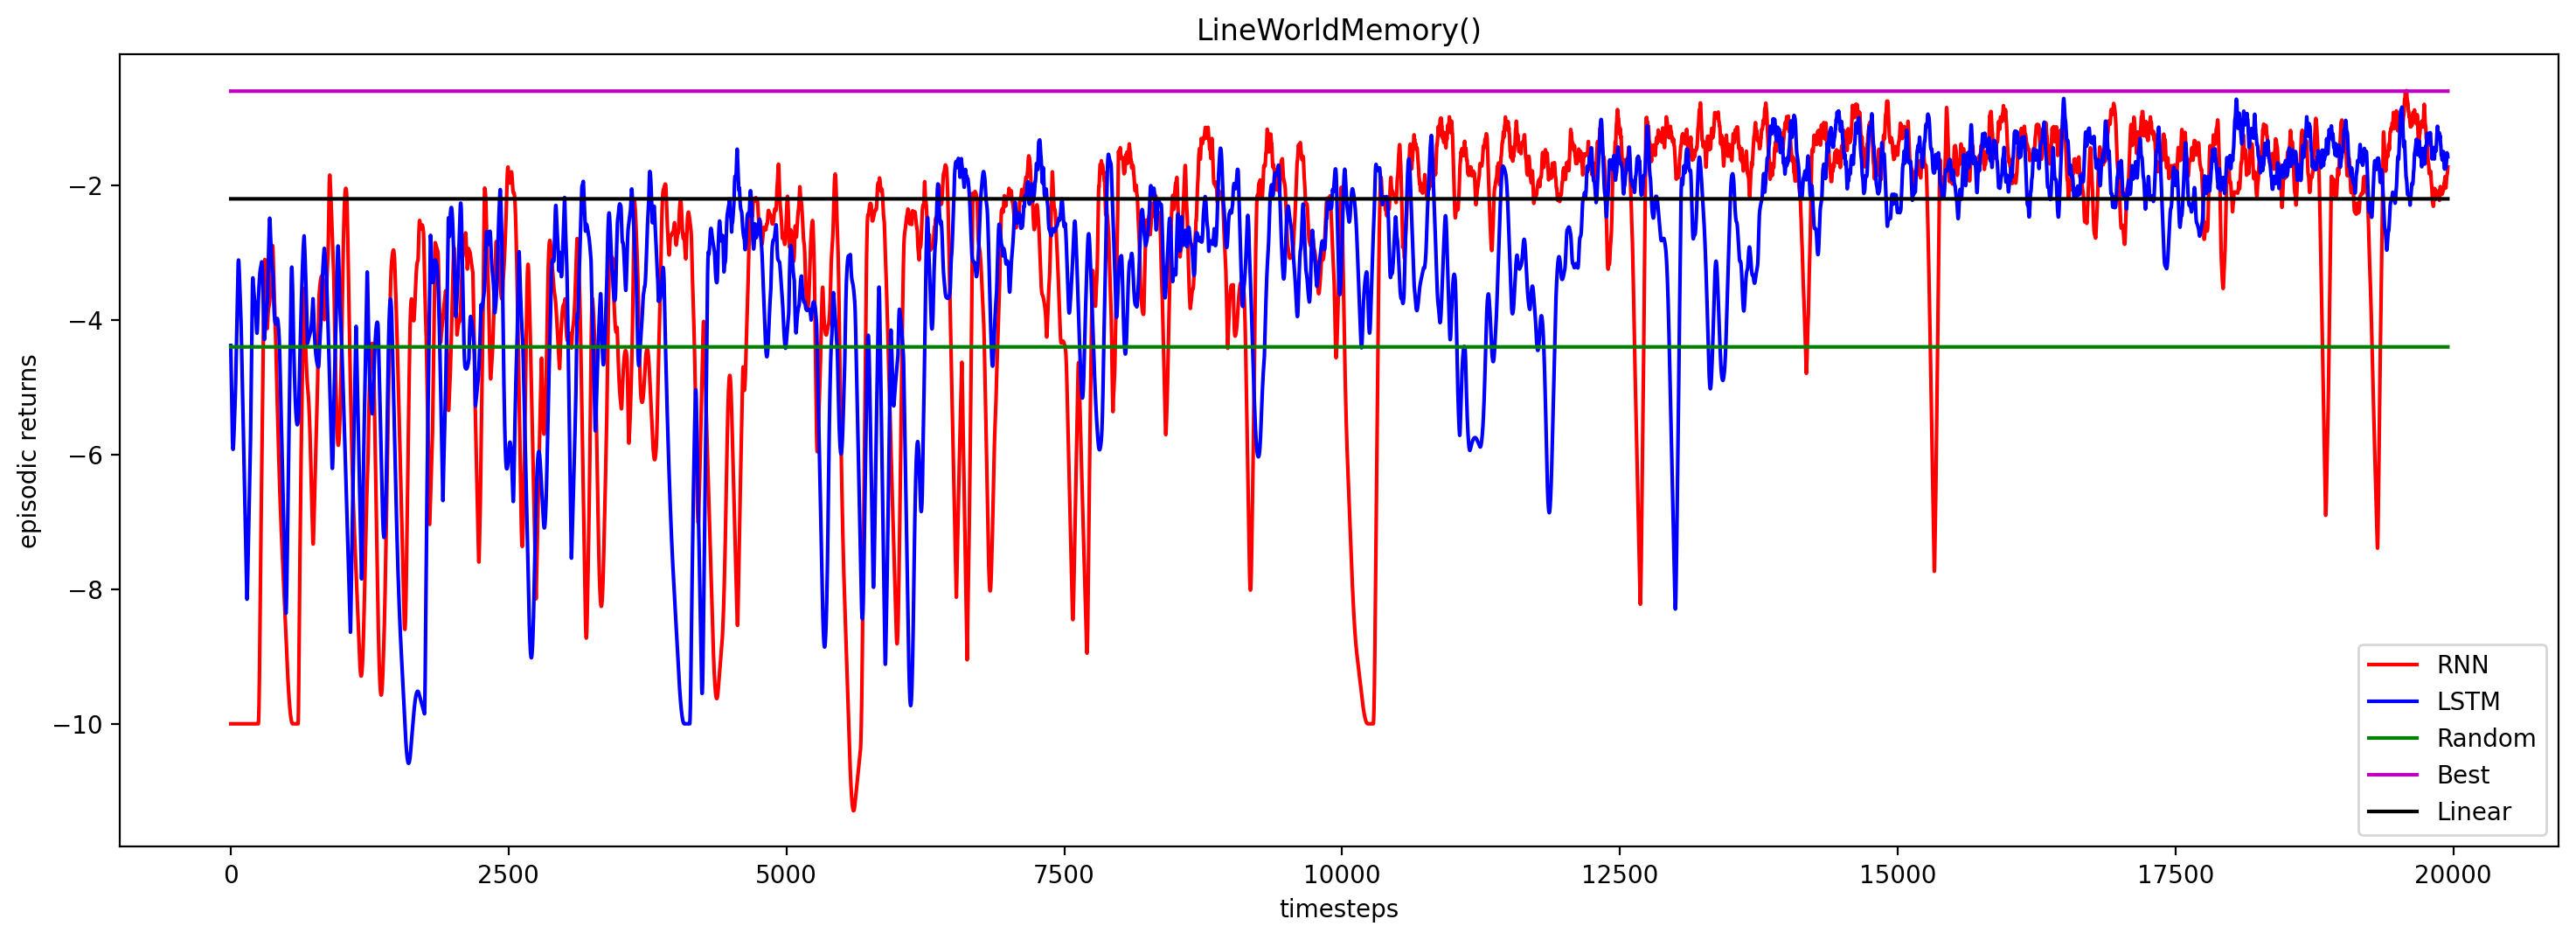

In [55]:
def train(env, agent, runs=1, ts_max=3000, store=False):
  no_episodes = 100
  horizon = 100
  track = True


  agents = []
  R_mat = []
  t_mat = []

  
  for r in tqdm(range(runs)):
    R_vec = []
    t_vec = []
    ts = 0
    while ts<ts_max:
      state = env.reset()
      state = torch.tensor(state).unsqueeze(0).float()

      rewards, actions = [], []
      # Take actions in the environment based on present policy
      for t in range(horizon):
        
        action = agent.select_action(state)
        if(action==2):
          pass
          # import pdb; pdb.set_trace()
        state2, r, done, _ = env.step(action)
        rewards.append(r)
        actions.append(action)
        if(done):
          break

        # Concatenate states here
        state2 = torch.tensor(state2).unsqueeze(0).float()
        state = torch.cat((state,state2),0)
        ts += 1

      # States are stored in state: ts x num_features
      returns = np.zeros(len(rewards))
      G = 0
      for t in range(len(rewards)):
        G = 0.9 * G + rewards[len(rewards)-t-1]
        returns[len(rewards)-t-1] = np.sum(rewards[t:]) # CHECK: discounting

      # Use states, returns and actions to update value of states
      agent.update(state, actions, returns)

      R_vec.append(np.sum(rewards))
      t_vec.append(ts)

    R_mat.append(R_vec)
    t_mat.append(t_vec)
    agents.append(agent)

  plt.plot(agent.loss_vec), plt.show()

  if(store):
    return agents, t_mat, R_mat
  return t_mat, R_mat

ts_max = 20000
# env = RememberLights(delay=10)
env = LineWorldMemory()
# r_rnn = train(env, Agent(env, net='rnn', eps=0.3), ts_max=ts_max, store=True)
# r_lstm = train(env, Agent(env, net='lstm', eps=0.3), ts_max=ts_max, store=True)
# r_linear = train(env, Agent(env, net='linear'), ts_max=ts_max)
# r_rand = train(env, Agent(env, net='rnn', eps=1), ts_max=ts_max)

rewards_dict = {
                'RNN': r_rnn[1:],
                'LSTM': r_lstm[1:],
                # 'Linear': r_linear,
                'Random': ([list(range(ts_max))],[[-4.4]*ts_max]),
                'Best': ([list(range(ts_max))],[[-0.6]*ts_max]),
                'Linear': ([list(range(ts_max))],[[-2.2]*ts_max])
               }
               

plot_rewards(rewards_dict, plot_seperate=False, clip=ts_max, title='LineWorldMemory()', smooth=50)

In [34]:
r_rnn[0][0].eps

0.01

tensor([[0., 0., 1., 0., 0., 0., 0.]])


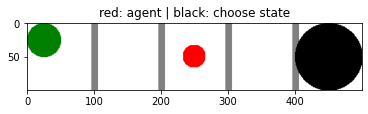

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


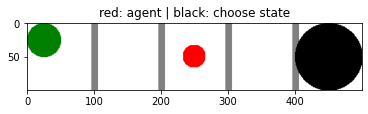

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


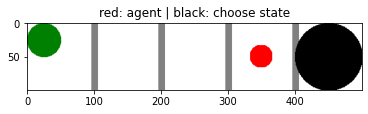

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]])


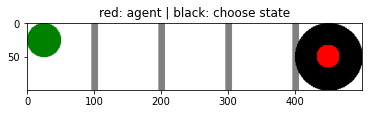

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])


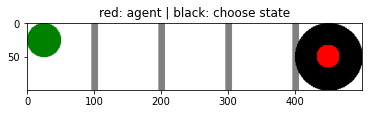

RuntimeError: ignored

In [49]:
# Visualize what the agent is doing
agent = r_rnn[0][2]
agent.eps=0

ts_max = 10
ts = 0
while ts < ts_max:
  state = env.reset()
  state = torch.tensor(state).unsqueeze(0).float()

  rewards, actions = [], []
  # Take actions in the environment based on present policy
  for t in range(100):
    
    action = agent.select_action(state)
    print(state)
    state2, r, done, _ = env.step(action)
    env.render()
    rewards.append(r)
    actions.append(action)
    if(done):
      raise

    # Concatenate states here
    state2 = torch.tensor(state2).unsqueeze(0).float()
    state = torch.cat((state,state2),0)
    ts += 1

In [28]:
# state, state2
env = RememberLights()
k = train(env, Agent(env, net='rnn'), store=True, runs=1)
list(k[0][0].network.named_parameters())

> <ipython-input-24-5bee28d3855d>(36)update()
-> self.updates += 1
(Pdb) results
*** NameError: name 'results' is not defined
(Pdb) returns
array([1., 1., 1., 1.])
(Pdb) returns.shape[0]
4
(Pdb) q


BdbQuit: ignored

# Rough

In [0]:
class LSTMNet(nn.Module, BaseNet):
	def __init__(self, in_size=7, hidden_size=7, out_size=4):
		"""
		in_size -> state space goes in here, so size of the state features
		hidden_size -> hidden vector size in the LSTM
		out_size -> number of actions
		"""
		super(LSTMNet, self).__init__()
		self.hidden_size = hidden_size
		self.lstm = nn.LSTM(input_size=in_size, hidden_size=hidden_size, num_layers=1)
		self.fc_head = layer_init(nn.Linear(hidden_size, output_dim))
		for p in list(self.parameters()): # initialize all parameters to 0
			p.data.fill_(0)
			print(p)

	def init_states(self, batch_size=1):
		hidden_state = torch.zeros(1, bs, self.body.feature_dim)
		cell_state = torch.zeros(1, bs, self.body.feature_dim)
		return hidden_state, cell_state

	def forward(self, x, hidden_state, cell_state): # CHECK: why can you not pass this states internally? 
		phi = self.body(tensor(x))
		phi = phi.unsqueeze(0)
		# phi = phi.view(1, phi.size(0), phi.size(1)) # seq_len, batch, feature
		y, (next_hidden_state, next_cell_state) = self.lstm(phi, (hidden_state, cell_state))  # y-> seq_len, batch, input_size      
		y = y.squeeze(0)
		q = self.fc_head(y)
		return q, (next_hidden_state, next_cell_state)